<a href="https://colab.research.google.com/github/Prananditha52/XceptionNet-for-pneumonia-detection/blob/main/XceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing the libraries

In [ ]:
import numpy as np 
import pandas as pd 
import cv2
from glob import glob
import splitfolders
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import RMSprop,Adam

In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
t='/content/drive/MyDrive/CBL_Assignment/TAsk-2/Normal'
h='/content/drive/MyDrive/CBL_Assignment/TAsk-2/Pneumonia'

In [ ]:
import os
len(os.listdir(h))

4758

splitting the dataset into training,testing and valiation folders.

In [ ]:
splitfolders.ratio('/content/drive/MyDrive/CBL_Assignment/TAsk-2', output="/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output", 
                   seed=42, ratio=(.8, .1, .1), 
                   group_prefix=None)

Copying files: 21295 files [14:50, 23.91 files/s]


In [ ]:
training_dir='/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/train'
validation_dir='/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/val'
test_dir='/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test'

train_n_dir='/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/train/Normal'
train_p_dir='/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/train/Pneumonia'
val_n_dir='/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/val/Normal'
val_p_dir='/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/val/Pneumonia'



In [ ]:
img = cv2.imread('/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/train/Pneumonia/1000_g2.jpg')
dimensions = img.shape
print(dimensions)

(256, 256, 3)


In [ ]:
import fnmatch
import os

print(len(fnmatch.filter(os.listdir('/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/Normal'), '*.jpg')))

1655


In [ ]:
print(len(fnmatch.filter(os.listdir('/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/Pneumonia'), '*.jpg')))

477


the images are rescaled and tranformed.

In [ ]:
train_datagen=ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 )

val_datagen=ImageDataGenerator(rescale=1.0/255)

test_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(training_dir,batch_size=128,target_size=(180,180),class_mode='binary')

val_generator=val_datagen.flow_from_directory(validation_dir,batch_size=128,target_size=(180,180),class_mode='binary')

test_generator=test_datagen.flow_from_directory(test_dir,batch_size=128,target_size=(180,180),class_mode='binary')

Found 17035 images belonging to 2 classes.
Found 2128 images belonging to 2 classes.
Found 2132 images belonging to 2 classes.


Creating the Xception model pre-trained on Imagenet dataset.

In [ ]:
model = Xception(weights= 'imagenet', include_top=False,input_shape= (180,180,3))

#freazing the trained layers
for layers in model.layers:
    layers.trainable = False

model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 89, 89, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

Fine-tuning the pre-trained model for the pneumonia dataset. The last layer of the model is flattened and then it is connected to a layer with 1024 neurons the next layer has 256 nodes with relu activation layer and the last layer with just one output node connected to a sigmoid activation layer.

In [ ]:
last_layer=model.get_layer('block14_sepconv2_act')
last_output = last_layer.output

x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

model=tf.keras.Model(model.input,x)

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
               metrics=['accuracy','Precision','Recall'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 89, 89, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


                                                                                                  
 block4_sepconv1 (SeparableConv  (None, 22, 22, 728)  188672     ['block4_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv1_bn (BatchNorma  (None, 22, 22, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 22, 22, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_se

training the model.

In [ ]:
history = model.fit(train_generator,validation_data=val_generator,epochs=10,steps_per_epoch=5,verbose=2)

Epoch 1/10
5/5 - 369s - loss: 41.9830 - accuracy: 0.6406 - precision: 0.2270 - recall: 0.2092 - val_loss: 22.4187 - val_accuracy: 0.2232 - val_precision: 0.2232 - val_recall: 1.0000 - 369s/epoch - 74s/step
Epoch 2/10
5/5 - 332s - loss: 6.3308 - accuracy: 0.6281 - precision: 0.2686 - recall: 0.2994 - val_loss: 5.1695 - val_accuracy: 0.2340 - val_precision: 0.2257 - val_recall: 1.0000 - 332s/epoch - 66s/step
Epoch 3/10
5/5 - 348s - loss: 3.4273 - accuracy: 0.6250 - precision: 0.2270 - recall: 0.3022 - val_loss: 2.0834 - val_accuracy: 0.7768 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 348s/epoch - 70s/step
Epoch 4/10
5/5 - 347s - loss: 1.2913 - accuracy: 0.6953 - precision: 0.3206 - recall: 0.2838 - val_loss: 1.6354 - val_accuracy: 0.7768 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 347s/epoch - 69s/step
Epoch 5/10
5/5 - 316s - loss: 0.9584 - accuracy: 0.7453 - precision: 0.3875 - recall: 0.2138 - val_loss: 0.8124 - val_accuracy: 0.5390 - val_precision: 0.3211 - val_r

Visualizing the Training and validation parameters for model estimation

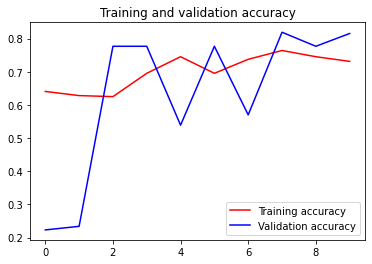

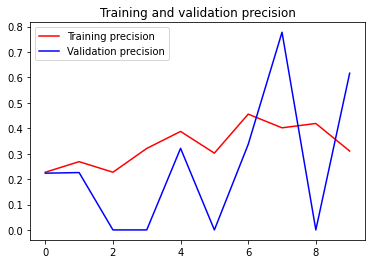

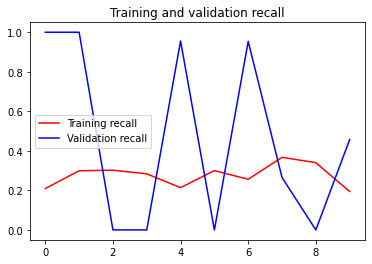

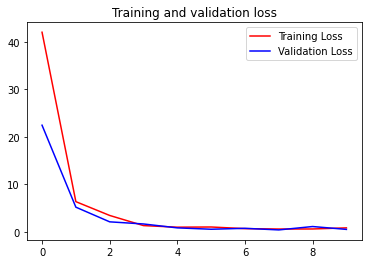

In [ ]:
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']

train_precision2=history.history['precision']
val_precision2=history.history['val_precision']

train_recall2=history.history['recall']
val_recall2=history.history['val_recall']

loss2 = history.history['loss']
val_loss2 = history.history['val_loss']
epochs = range(len(acc2))


plt.plot(epochs, acc2, 'r', label='Training accuracy')
plt.plot(epochs, val_acc2, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, train_precision2, 'r', label='Training precision')
plt.plot(epochs, val_precision2, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

plt.plot(epochs, train_recall2, 'r', label='Training recall')
plt.plot(epochs, val_recall2, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

plt.plot(epochs, loss2, 'r', label='Training Loss')
plt.plot(epochs, val_loss2, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
eval_result3 = model.evaluate_generator(test_generator, 2132,verbose=1)
print('loss  :', eval_result3[0])
print('accuracy  :', eval_result3[1])
print('Precision :', eval_result3[2])
print('Recall :', eval_result3[3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


  17/2132 [..............................] - ETA: 9:33:34 - loss: 0.4974 - accuracy: 0.8180 - precision: 0.6297 - recall: 0.4528

2132/2132 [==============================] - 276s 122ms/step - loss: 0.4974 - accuracy: 0.8180 - precision: 0.6297 - recall: 0.4528
loss  : 0.4973980486392975
accuracy  : 0.8180112838745117
Precision : 0.6297376155853271
Recall : 0.4528301954269409


Dividing the test folders into appropriate folders to perform 5-fold cross-validation.

In [ ]:
import os
directory = "5-fold"
parent_dir = "/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test"
path = os.path.join(parent_dir, directory)
os.mkdir(path)

In [ ]:
parent_dir = "/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/5-fold"
for i in range(5):
  path = os.path.join(parent_dir,"Val-"+str(i))
  os.mkdir(path)

In [ ]:
for i in range(5):
  path = os.path.join("/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/5-fold/Val-"+str(i),"Normal")
  path2 = os.path.join("/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/5-fold/Val-"+str(i),"Pneumonia")
  os.mkdir(path)
  os.mkdir(path2)

In [ ]:
import os
import shutil
import math

In [ ]:
origin_n = '/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/Normal'
Origin_p='/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/Pneumonia'

In [ ]:
files_n = os.listdir(origin_n)
files_p = os.listdir(Origin_p)

In [ ]:
len(files_n)

1655

In [ ]:
l=math.floor(len(files_n)/5)
for i in range(5):
  target = '/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/5-fold/Val-'+str(i)+'/Normal'
  files_n=os.listdir(origin_n)
  h=0
  for file_name in files_n:
    if(h<l):
      shutil.copy(origin_n+"/"+file_name, target+"/"+file_name)
      os.remove(origin_n+"/"+file_name)
      h=h+1
    else:
      break
  


In [ ]:
l_p=math.floor(len(files_p)/5)
for i in range(5):
  target = '/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/5-fold/Val-'+str(i)+'/Pneumonia'
  files_P=os.listdir(Origin_p)
  h=0
  for file_name in files_P:
    if(h<l_p):
      shutil.copy(Origin_p+"/"+file_name, target+"/"+file_name)
      os.remove(Origin_p+"/"+file_name)
      h=h+1
    else:
      break
  

In [ ]:
test_val_datagen=ImageDataGenerator(rescale=1.0/255)

In [ ]:
len(os.listdir('/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/5-fold/Val-3/Pneumonia'))


95

5-fold cross validation.

In [ ]:
for i in range(5):
  test_val_generator=test_val_datagen.flow_from_directory('/content/drive/MyDrive/CBL_Assignment/TAsk-2/Output/test/5-fold/Val-'+str(i),
                                                          batch_size=19,target_size=(180,180),class_mode='binary')
  print("---------------------------------------FOLD"+str(i)+"---------------------------------------------------------")
  model.fit(test_val_generator,epochs=10,steps_per_epoch=5,verbose=2)
  

Found 426 images belonging to 2 classes.
---------------------------------------FOLD0---------------------------------------------------------
Epoch 1/10
5/5 - 18s - loss: 0.3883 - accuracy: 0.8316 - precision: 0.5714 - recall: 0.4444 - 18s/epoch - 4s/step
Epoch 2/10
5/5 - 17s - loss: 0.3402 - accuracy: 0.8632 - precision: 0.7222 - recall: 0.6190 - 17s/epoch - 3s/step
Epoch 3/10
5/5 - 16s - loss: 0.4750 - accuracy: 0.8632 - precision: 0.7368 - recall: 0.6364 - 16s/epoch - 3s/step
Epoch 4/10
5/5 - 15s - loss: 0.3168 - accuracy: 0.8690 - precision: 0.7143 - recall: 0.7500 - 15s/epoch - 3s/step
Epoch 5/10
5/5 - 19s - loss: 0.2194 - accuracy: 0.9053 - precision: 0.7500 - recall: 0.7059 - 19s/epoch - 4s/step
Epoch 6/10
5/5 - 15s - loss: 0.3653 - accuracy: 0.8452 - precision: 0.6000 - recall: 0.5625 - 15s/epoch - 3s/step
Epoch 7/10
5/5 - 18s - loss: 0.2527 - accuracy: 0.9158 - precision: 0.8636 - recall: 0.7917 - 18s/epoch - 4s/step
Epoch 8/10
5/5 - 17s - loss: 0.5566 - accuracy: 0.8421 - pr